### **Introduction**
In linear regression we model the target as a linear combination of the predictors plus an error term. 

$$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p + \varepsilon$$

- $y$: Target  
- $x_1, ..., x_p$: Predictors  
- $\beta_0, ..., \beta_p$: Parameters  
- $\varepsilon$: Error term  

In two-dimensions we fit a line line, for 3-dimensions we fit a plane and for higher dimensions we fit a multi-dimensional surface. 

For example, suppose we have measured the weight and height of a group of people and we want to predict height using weight.

$height = \beta_0 + \beta_1 weight + \varepsilon$

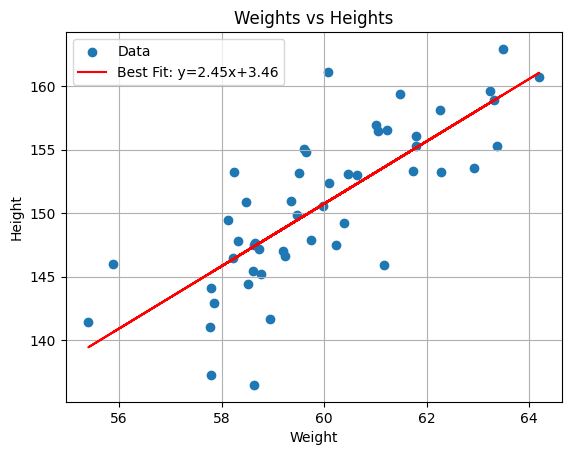

In [15]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

# Generate data
weights = np.random.normal(loc=60, scale=2, size=50)
heights = 2.5 * weights + np.random.normal(loc=0, scale=5, size=50)

# Compute best fit line (degree 1 polynomial)
slope, intercept = np.polyfit(weights, heights, 1)
line = slope * weights + intercept

# Plot
plt.figure()
plt.scatter(weights, heights, label='Data')
plt.plot(weights, line, color='red', label=f'Best Fit: y={slope:.2f}x+{intercept:.2f}')
plt.title("Weights vs Heights")
plt.xlabel("Weight")
plt.ylabel("Height")
plt.grid(True)
plt.legend()
plt.show()


### **Residual Sum of Squares**
We fit a linear model by finding the parameters which minimise the residual sum of squares (RSS).  
Linear Model: $y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_k x_k + \varepsilon$ 
Observed Value: $(x_{1,i}, x_{2,i}, \dots, x_{k,i},\ y_i)$
Fitted Value: $\hat{y}_i = \beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i} + \cdots + \beta_k x_{k,i}$
Residual: $r_i = y_i - \hat{y}_i = y_i - \left( \beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i} + \cdots + \beta_k x_{k,i} \right)$
Residual Sum of Squares: $\sum_{i=1}^n r_i^2 = \sum_{i=1}^n \left( y_i - \hat{y}_i \right)^2$
Objective: $\quad \min_{\beta_0, \beta_1, \dots, \beta_k} \sum_{i=1}^n r_i^2$

In some cases we can find the parameters analytically by solving for when the derivative of RSS is 0. However, in practice these parameters are usually estimated computationally using gradient decent. 

### **Assumptions**
When fiting a linear model, the following assumption are made about the underlying data:

1. **Linearity**: The target is a linear combination of the predictors $y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_k x_k + \varepsilon$

2. **Independent & Identically Distributed (i.i.d.) Observations**: The observations $(x_i, y_i)$ are i.i.d

3. **Independent & Identically Normally Distributed (i.i.n.d.) Errors**: The error terms $\varepsilon_i$ are i.i.d.n.

4. **Unbiased Errors**: $\mathbb{E}(\varepsilon_i) = 0$

5. **Homoskedastic Errors**: $\text Var(\varepsilon_i) = \sigma^2$.

6. **No Perfect Multicollinearity**: The predictors are not perfectly linearly dependent. That is, no predictor is a perfect linear combination of the others

Assumptions 3-5 can be combined into one assumption: $\varepsilon_i \sim N(0, \sigma^2)$
 
Note that the error term having non-constant variance is refered to as **heteroskedasticity**.


### Linearity
If the response is not a linear combination of the parameters, the coefficients may be biased and predictions can be unreliable. There are two main ways to test for linearity:
1. Residuals vs Fitted Values Plot
    - This should look like random noise around 0 (i.e. normally distributed)
    - A U-shape or S-shape may be evidence of non-linearity
2. Ramsey RESET Test
    - Adds squared/cubic terms of fitted values to the model
    - Null hypothesis: Model is correctly specified (linear)
    - Alternative hypothesis: Non-linearity present.

If non-linearity is present you can try to take transformations of the predictors (e.g. log, polynomial etc). If non-linearity is still present, you may consider moving to a different model that can handle non-linearity (e.g. XGBoost)

In the example below, we first generate a data which is not a linear combination of the predictors. We fit a deliberately mis-specified linear model and plot the residuals vs fitted values. We observe a clear quadratic shape rather than symmetric noise around 0 and therefore conclude the presence of non-linearity. Next we fit a correctly specified model and again plot the residuals vs fitted values. We do not detect non-linearity due to the symmetreic noise around 0.  

Additionally, we perform two Ramsey RESET hypothesis tests to detect non-linearity in each of the two models. As expected, we detect non-linearity (p < 0.05) in the misspecified model and fail to detect it in the correctly specified model. 

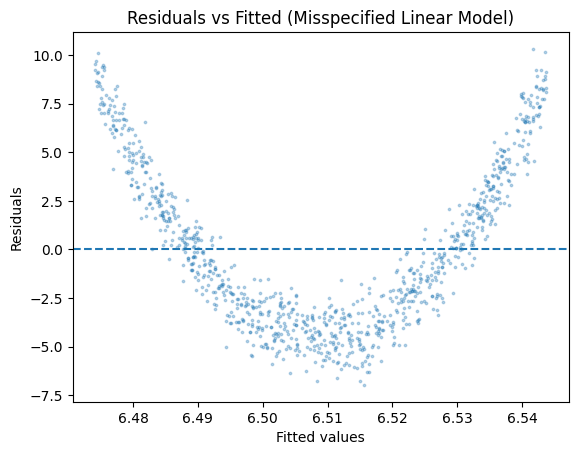

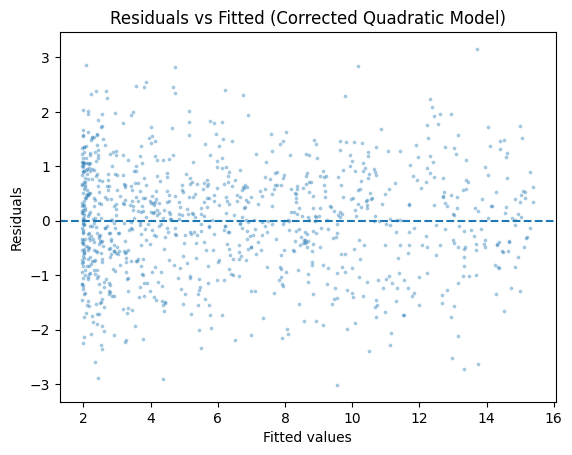

RESET test (bad model):
Chi2-stat: 15322.28027394268
p-value: 0.0
We reject the Null hypothesis (at the 5% significance level) that the model was correctly specified. That is, we detect non-linearity

RESET test (corrected model):
Chi2-stat: 0.4327031024670872
p-value: 0.5106655492104478
We do not reject the Null hypothesis (at the 5% significance level) that the model was correctly specified. That is, we do not detect non-linearity


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import linear_reset

# 1. Generate data (true quadratic relationship)
rng = np.random.default_rng(42)
n = 1000
x = rng.uniform(-3, 3, n)
eps = rng.normal(0, 1, n)
y = 2 + 1.5 * x**2 + eps   # quadratic in x

df = pd.DataFrame({"y": y, "x": x})

# 2. Misspecified linear model (i.e. non-linearity present)
model_bad = smf.ols("y ~ x", data=df).fit()
df["resid_bad"] = model_bad.resid
df["fitted_bad"] = model_bad.fittedvalues

plt.scatter(df["fitted_bad"], df["resid_bad"], alpha=0.3, s=3)
plt.axhline(0, ls="--")
plt.title("Residuals vs Fitted (Misspecified Linear Model)")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

# 3. Corrected model with quadratic term
df["x2"] = df["x"]**2
model_fix = smf.ols("y ~ x + x2", data=df).fit()
df["resid_fix"] = model_fix.resid
df["fitted_fix"] = model_fix.fittedvalues

plt.scatter(df["fitted_fix"], df["resid_fix"], alpha=0.3, s=3)
plt.axhline(0, ls="--")
plt.title("Residuals vs Fitted (Corrected Quadratic Model)")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

# 4. Ramsey RESET test to detect non-linearity

# For the misspecified model
reset_bad = linear_reset(model_bad, power=2, test_type='fitted')
print("RESET test (bad model):")
print("Chi2-stat:", reset_bad.statistic)
print("p-value:", reset_bad.pvalue)
print("We reject the Null hypothesis (at the 5% significance level) that the model was correctly specified. That is, we detect non-linearity")

# For the corrected model
reset_fix = linear_reset(model_fix, power=2, test_type="fitted")
print("\nRESET test (corrected model):")
print("Chi2-stat:", reset_fix.statistic)
print("p-value:", reset_fix.pvalue)
print("We do not reject the Null hypothesis (at the 5% significance level) that the model was correctly specified. That is, we do not detect non-linearity")

### **I.I.D. Observations**
This assumption cannot be tested statistically and is more of an assumption about the underlying phenomenon you are observing and the data collection process. Generally, if random sampling is used, independence of observations is a reasonable assumption. However, if the same process is measured over time (e.g. temperature of a room) then this assumption is unlikely to hold. In the case of dependent observations, the estimated coefficients may still be unbiased however the standard errors will be wrong This can lead to invalid hypothesis tests and confidence intervals. 

Often time-series datasets break this assumption since the observations are usually time dependent. That is, the value now is related to the value in the past. In the example of time series, you can use autoregressive models such as ARIMA instead. 

### **Independence of Errors**
If independence of errors is violated the coefficient estimates are still unbiased, but standard errors are wrong and consequently predictions are unreliable. This is checked by examining the residuals. 

We use the Durbin-Watson hypothesis test to detect autocorrelation in residuals. The statistic ranges from 0-4 and is interpretted as follows:
- ≈2 no autocorrelation
- <2 positive correlation
- \>2 negative correlation

In the example below we first generate a dataset where the error values are directly computed from the previous values (thus introducing dependence). We fit a simple linear model and compute the residuals. Then we perform the Durbin-Watson hypothesis test on each set of residuals and detect to detect autocorrelation of the residuals. Next we generate an independent dataset, fit a simply linear model and compute the residuals. This time, the Durbin-Watson hypothesis test fails to detect autocorrelation of the residuals. 

In [17]:
from statsmodels.stats.stattools import durbin_watson

# 1. Generate autocorrelated data (i.e. values depend on previous values)
n = 1000
x = range(n)
eps = rng.normal(0, 1, n)
rho = 0.8  # autocorrelation strength
for i in range(n):
    if i == 0:
        eps[i] = rng.normal(0, 1)
    else:
        eps[i] = rho * eps[i-1] + rng.normal(0, 1)

y = 10 + 3 * np.arange(n) + eps

autocorrelated_df = pd.DataFrame({"y": y, "x": x})

# 2. Fit linear model
autocorrelated_model = smf.ols("y ~ x", data=autocorrelated_df).fit()
autocorrelated_df["resid_"] = autocorrelated_model.resid
autocorrelated_df["fitted_"] = autocorrelated_model.fittedvalues

# 3. Compute Durbin-Watson statistic
autocorrelated_dw = durbin_watson(autocorrelated_model.resid)
print("Durbin-Watson:", autocorrelated_dw)
print("Durbin-Watson hypothesis tests detects positive autocorrelation")

# 4. Generate independent data
n = 1000
x = range(n)
eps = rng.normal(0, 1, n)
y = []
for i in x:
    #  No dependency of residuals
    y.append(10 + 2 * x[i] + eps[i])

df = pd.DataFrame({"y": y, "x": x})

# 5. Fit linear model
model = smf.ols("y ~ x", data=df).fit()
df["resid_"] = model.resid
df["fitted_"] = model.fittedvalues

# 6. Compute Durbin-Watson statistic
dw = durbin_watson(model.resid)
print("Durbin-Watson:", dw)
print("Durbin-Watson hypothesis tests fails to detect autocorrelation")


Durbin-Watson: 0.3866729795485667
Durbin-Watson hypothesis tests detects positive autocorrelation
Durbin-Watson: 1.9834896405663813
Durbin-Watson hypothesis tests fails to detect autocorrelation


### **$N(0, \sigma^2)$ Errors**
If the errors are not normally distributed with mean 0 and constant variance $N(0, \sigma^2)$ the coefficient estimates are still unbiased, but standard errors are wrong and consequently predictions are unreliable. We can check this in the following two ways:
1. Quantile-Quantile (QQ) plot
    - Plots the quantiles of the residuals (scaled to $N(0, 1)$) against the quantiles of a stanadrd normal distribution $N(0, 1)$
    - If the residuals are normally distribured, the points of the qq plot should lie of a straight line with gradient 1
    - If there are large deviations from this straight line, it suggests the residuals are not normal
2. Shapiro-Wilk Hypothesis Test
    - Null hypothesis: Errors are drawn from a normal distribution
    - Alternative: Errors are not drawn from a normal distribution

In the example below we first generate a dataset where the error values are not from a normal distribution and then a dataset where the errors are normal. We fit a simple linear model to each, compute the residuals and then create the QQ plots. In the first case we see the points of the QQ plot deviate far from the straight line thus suggesting the errors are not $N(0, \sigma^2)$. In the second QQ plot the points roughly follow the straight line thus suggesting the errors are $N(0, \sigma^2)$. We also annotate the QQ plots with the Shapiro-Wilk p-value. These tests provide further evidence in line with the QQ plots regarding the normality of the residuals. 

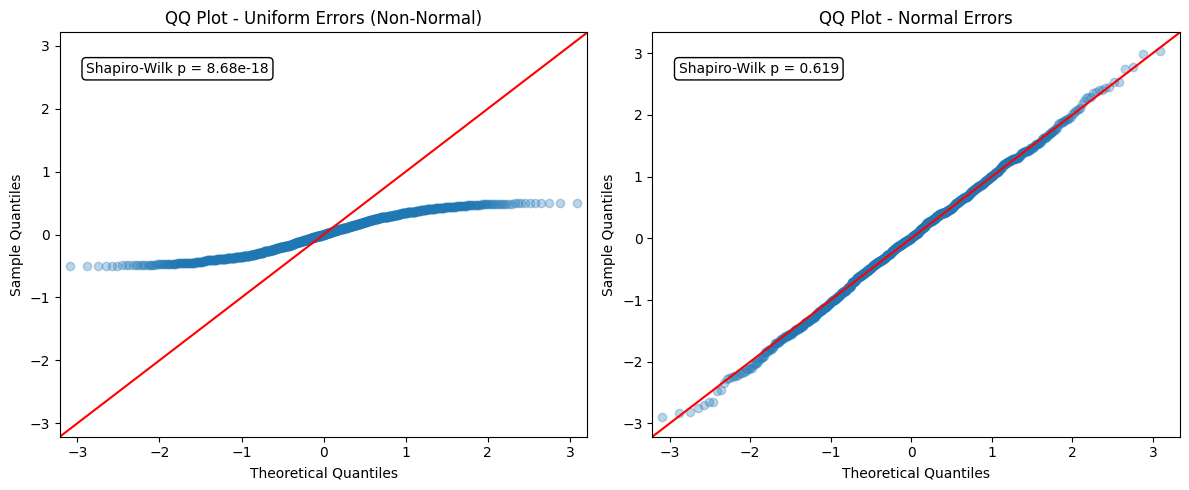

In [18]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy.stats import shapiro

rng = np.random.default_rng(42)

# 1. Generate dataset with non-normal residuals (Uniform errors)
n = 1000
x = np.arange(n)
error_non_normal = rng.uniform(0, 1, n)
y_non_normal = 5 + 8 * x + error_non_normal
df_non_normal = pd.DataFrame({"y": y_non_normal, "x": x})

# 2. Generate dataset with normal residuals (Normal errors)
error_normal = rng.normal(0, 1, n)
y_normal = 5 + 8 * x + error_normal
df_normal = pd.DataFrame({"y": y_normal, "x": x})

# 3. Fit models and compute residuals
model_non_normal = smf.ols("y ~ x", data=df_non_normal).fit()
df_non_normal["resid_"] = model_non_normal.resid

model_normal = smf.ols("y ~ x", data=df_normal).fit()
df_normal["resid_"] = model_normal.resid

# 4. Compute Shapiro-Wilk test results
stat_non_norm, p_non_norm = shapiro(df_non_normal["resid_"])
stat_norm, p_norm = shapiro(df_normal["resid_"])

# 5. Create QQ plots with annotations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sm.qqplot(df_non_normal["resid_"], line="45", ax=axes[0], alpha=0.3)
axes[0].set_title("QQ Plot - Uniform Errors (Non-Normal)")
axes[0].annotate(f"Shapiro-Wilk p = {p_non_norm:.3g}", xy=(0.05, 0.9), 
                 xycoords="axes fraction", fontsize=10, 
                 bbox=dict(boxstyle="round", fc="w"))

sm.qqplot(df_normal["resid_"], line="45", ax=axes[1], alpha=0.3)
axes[1].set_title("QQ Plot - Normal Errors")
axes[1].annotate(f"Shapiro-Wilk p = {p_norm:.3g}", xy=(0.05, 0.9), 
                 xycoords="axes fraction", fontsize=10, 
                 bbox=dict(boxstyle="round", fc="w"))

plt.tight_layout()
plt.show()


### **No Perfect Multicolinearity**
If perfect multicollinearity exists (e.g. including both “Age in years” and “Age in months”), the model cannot uniquely estimate regression coefficients. That makes the design matrix $X$ singular $\rightarrow$ its determinant is $0$, and it cannot be inverted. Since OLS coefficient estimation relies on $(X'X)^{-1}$, the model cannot be estimated uniquely.

In practice, it is also important to check for high (but not perfect) multicollinearity, where predictors are strongly correlated. While the model can still be estimated, high multicollinearity inflates the standard errors of the coefficients, making inference unreliable. A common way to assess this is by computing the **Variance Inflation Factor (VIF)** for each predictor. For a given predictor $X_j$, the Variance Inflation Factor is:

$\mathrm{VIF}_j = \frac{1}{1 - R_j^2}$

where $R_j^2$ is the coefficient of determination from regressing $X_j$ on all the other predictors in the model.

If $X_j$ is uncorrelated with the other predictors, then $R_j^2 \approx 0$, so:

$\mathrm{VIF}_j \approx 1$

→ No inflation of variance.

If $X_j$ is highly correlated with the other predictors, then $R_j^2$ is close to 1, so:

$\mathrm{VIF}_j \gg 1$

→ The variance of $\hat{\beta}_j$ is much larger than it would be without collinearity.

So VIF tells you how much the variance of a coefficient is “inflated” due to collinearity.

The example below shows two data sets, one with perfect multicollinearity and one without. In each case we compute the VIF for each predictor and demonstrate that in the first case, we have perfect multicollinearity. Note that the model summary says "The smallest eigenvalue is x. This might indicate that there are strong multicollinearity problems or that the design matrix is singular." In reality this value is 0 and the small difference stated is due to numeric methods (i.e. computers can't compute it exactly). 


In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Generate data with perfect multicollinearity
n = 1000
x1 = range(n)
x2 = 4 * np.arange(n)
eps = rng.normal(0, 1, n)
y = 10 + 2 * np.arange(n) + 4 * np.arange(n) + eps

perfect_mcl_df = pd.DataFrame({"y": y, "x1": x1, "x2": x2})

# 2. Generate data without perfect multicollinearity
n = 1000
x1 = rng.normal(0, 1, n)
x2 = rng.normal(0, 1, n)
eps = rng.normal(0, 1, n)
y = 10 + 2 * np.arange(n) + eps

df = pd.DataFrame({"y": y, "x1": x1, "x2": x2})

# Compute VIF (perfect mcl)
perfect_mcl_model = smf.ols("y ~ x1 + x2", data=perfect_mcl_df).fit()
print(perfect_mcl_model.summary())

# Compute VIFs (perfect mcl)
X = perfect_mcl_model.model.exog
for i, name in enumerate(perfect_mcl_model.model.exog_names):
    print(name, variance_inflation_factor(X, i))

# Compute VIF (no mcl)
model = smf.ols("y ~ x1 + x2", data=df).fit()
print(model.summary())

# Compute VIFs (no mcl)
X = model.model.exog
for i, name in enumerate(model.model.exog_names):
    print(name, variance_inflation_factor(X, i))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.940e+09
Date:                Tue, 17 Feb 2026   Prob (F-statistic):               0.00
Time:                        12:27:39   Log-Likelihood:                -1428.0
No. Observations:                1000   AIC:                             2860.
Df Residuals:                     998   BIC:                             2870.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0242      0.064    157.028      0.0

/home/azureuser/localfiles/Projects/data_science/.venv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


## **Confounding**
Confounding is the phenomenon whereby coefficients can be estimated in a misleading way due to the absence of highly relevant predictive factors. 

For example, suppose we were interested in how smoking affects lung capacity in children. If we were to fit a linear model of lung capacity against rate of smoking, we would likely observe that smoking has a positive correlation with lung capacity. This may lead us to the false conclusion that children who smoke more are more likely to have larger lungs. However we have missed off a highly relevant predictor, namely age. Age is both highly correlated with lung capacity and smoking rate. Indeed, older children will tend to have larger lungs and be more likely to smoke. So if we refit our model, this time also including age as a predictor, we will likely see a different result. That is, after accounting for age, smoking will be associated with smaller lung capacities. 

Confounding leads to biased or misleading estimates of effect sizes and directions, often due to omitted variables, and must be carefully controlled for to avoid false conclusions. It is difficult to directly prevent confounding but the following may help:
- Domain knowledge: Identify potential confounders before modeling (e.g., age, gender, socioeconomic status in medical studies).
- Study design: Randomised controlled trials are designed to eliminate confounding by randomly assigning treatment.

In the example below we generate a dataset where two predictors are both correlate with each other as well as the target. When we fit a model with just one predictor we get a very different estimation of the effect than using both predictors. 


In [20]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# --- Step 1. Generate data ---
np.random.seed(0)
n = 200

# Confounder (Z)
Z = np.random.normal(0, 10, n)

# Predictor (X), correlated with Z
X = Z + np.random.normal(0, 1, n)

# Outcome (Y) depends on both X and Z
eps = np.random.normal(0, 1, n)
Y = 2*Z - 1.5*X + eps

# Put into a DataFrame
df = pd.DataFrame({"X": X, "Z": Z, "Y": Y})


# --- Step 2. Fit models ---

# Model A: Y ~ X only (ignores confounder)
Xa = sm.add_constant(df["X"])
modelA = sm.OLS(df["Y"], Xa).fit()
print("Model A (ignoring confounder):")
print(modelA.summary(), "\n")
print(f"When ommitting the confounder Z, the coefficient for X is {modelA.params['X']:.4f} implying a positive correlation between X and Y")

# Model B: Y ~ X + Z (includes confounder)
Xb = sm.add_constant(df[["X", "Z"]])
modelB = sm.OLS(df["Y"], Xb).fit()
print("Model B (with confounder):")
print(modelB.summary())
print(f"When including the confounder Z, the coefficient for X is {modelB.params['X']:.4f} implying a negative correlation between X and Y")

print("Notice how the inclusion of the confounding factor caused the model to completely change its estimate of the size and direction of the effect of X on Y.")


Model A (ignoring confounder):
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     1205.
Date:                Tue, 17 Feb 2026   Prob (F-statistic):           4.08e-86
Time:                        12:27:39   Log-Likelihood:                -417.34
No. Observations:                 200   AIC:                             838.7
Df Residuals:                     198   BIC:                             845.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1682

### **Outliers**
Outliers are particularly problematic in linear regression due to the nature of the objective function. Linear regression tries to minimise the sum of the squared residuals; outliers may have very large residuals, which when squared make up a large proportion of the objective value. So linear models can be heavily influenced by the presence of outliers, to the detriment of their ability to predict non-outlier values. It is therefore important to identify outliers since they may distort the model.

In order to detect outliers we first need to define what we mean by an outlier. Intuitively, defining an outlier as a prediction which is very far away from all other predictions seems sensible. This idea of being far away from the other predictions is called leverage. However high leverage alone does not necessarily imply a point is an outlier. That is because, even if a point has high leverage, it may still sit very close to the extrapolated regression line and so might not actually exert much influence on the model. We define a point's influence as its leverage x residual. This captures the idea that a point not only needs to be far from other predictions, but also far from the regression line (i.e. high residual) to distort the model and therefore be considered an outlier. 

More technically we define leverage and influence as follows:

$$
leverage_i = \hat{y}_i - \frac{1}{n}\sum_{j=1}^n \hat{y}_j
$$

So the leverage of a given point is the difference between its fitted value and the average of all fitted values. 

$$
influence_i = leverage_i * residual_i = (\hat{y}_i - \frac{1}{n}\sum_{j=1}^n \hat{y}_j) * (\hat{y}_i - y_i)
$$

Cook's distance is used to detect outliers. It works by comparing the fitted values of a model including the given point with the fitted values of a model fit with the given point removed. So it effecitvely measures how much a given point is effecting the model.

$$
Cook's\;Distance_i = \frac{1}{p \hat{\sigma}^2}\sum_{j=1}^n (\hat{y}_j - \hat{y}_{j(i)})^2
$$

where
- $p$: number of model parameters including the intercept  
- $\hat{\sigma}^2$: estimated error variance  
- $\hat{y}_j$: fitted value using all data  
- $\hat{y}_{j(i)}$: fitted value when point i is omitted

Note that it can also be expressed in terms of the residuals and leverage as follows:

$$
Cook's\;Distance_i = \frac{e_i^2}{p \, \sigma^2} \cdot \frac{h_{ii}}{(1 - h_{ii})^2}
$$

where
- $e_i = y_i - \hat{y_i}$ is the raw residual
- $p$ is the number of model parameters including the intercept  
- $\hat{\sigma}^2$ is the estimated error variance  
- $h_{ii}$ is the leverage of point $i$

Hence a point has a large Cook's Distanace if it both:
- Usual in $X$ (i.e. high leverage $h_{ii}$) 
- Poorly fitted (i.e. large residual $e_i = y_i - \hat{y_i}$)

Generally points such that $Cook's\;Distance_i > 1$ should be investigated. 

In the examples below, we demonstrate a point with high/low leverage/influence. In each case we plot the regression line with and without the given point and compute the Cook's Distance. 

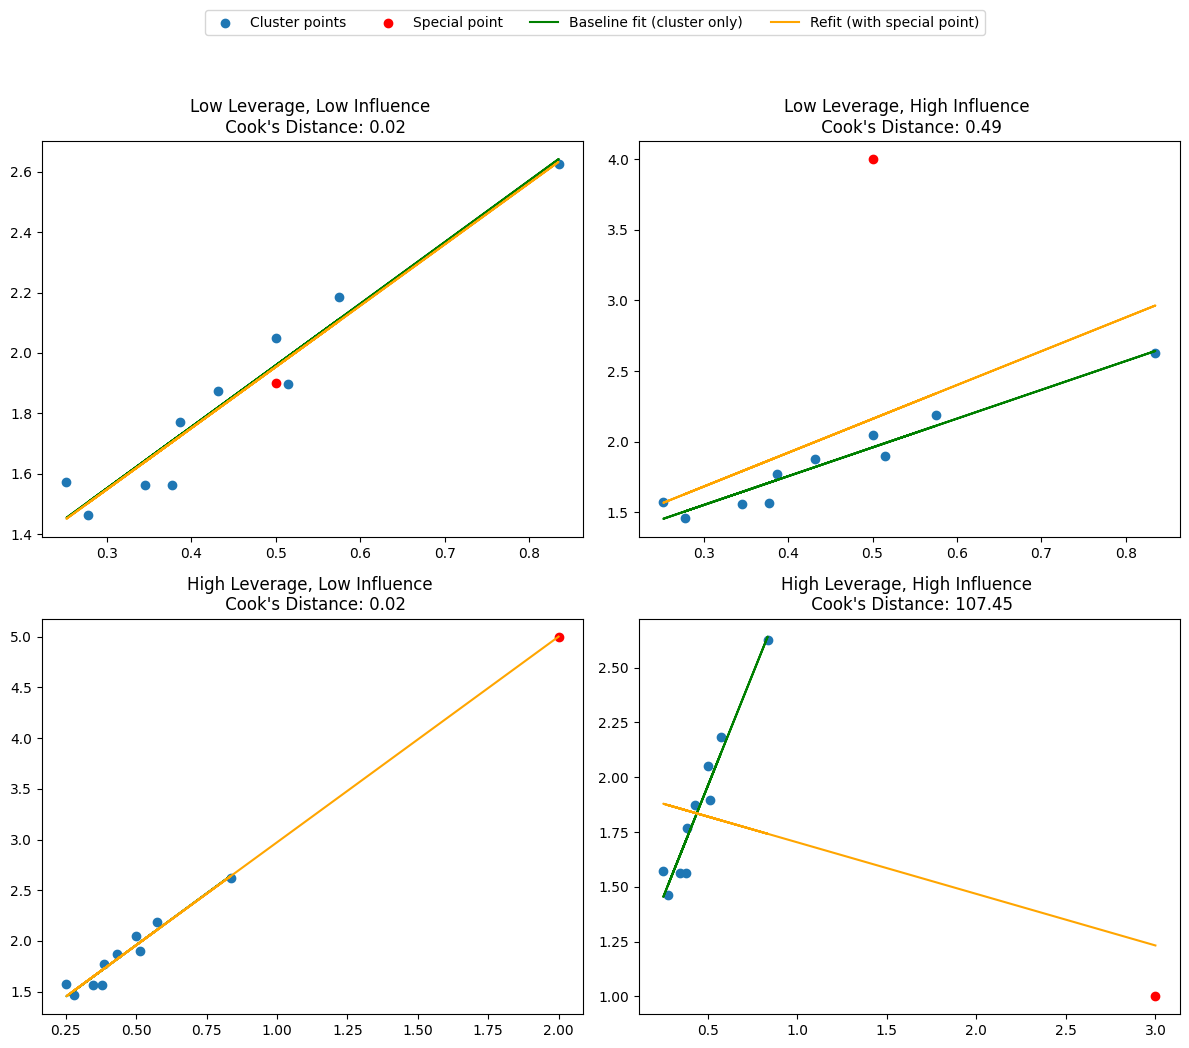

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Set random seed for reproducibility
rng = np.random.default_rng(7)

# Generate base cluster near the origin with a simple linear relationship y ≈ 2x + 1
n = 10
X_base = rng.normal(0.5, 0.25, size=n)
y_base = 2 * X_base + 1 + rng.normal(0, 0.1, size=n)

additional_points = {
    "Low Leverage, Low Influence": (0.5, 1.9),
    "Low Leverage, High Influence": (0.5, 4),
    "High Leverage, Low Influence": (2, 5),
    "High Leverage, High Influence": (3.0, 1.0)
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
handles = []
labels = ['Cluster points', 'Special point', 'Baseline fit (cluster only)', 'Refit (with special point)']

for ax, (point_type, (x_new, y_new)) in zip(axes.flatten(), additional_points.items()):
    # Fit model without point
    Xb = sm.add_constant(X_base)
    model_base = sm.OLS(y_base, Xb).fit()
    intercept_base, slope_base = model_base.params

    # Fit model with new point
    X_all = np.concatenate([X_base, [x_new]])
    y_all = np.concatenate([y_base, [y_new]])
    Xa = sm.add_constant(X_all)
    model_all = sm.OLS(y_all, Xa).fit()
    intercept_all, slope_all = model_all.params

    # Compute Cook's Distance
    cooks_distances = model_all.get_influence().cooks_distance[0]
    cd_new_point = cooks_distances[-1]

    # Plotting
    h1 = ax.scatter(X_base, y_base)
    h2 = ax.scatter(x_new, y_new, color='red')
    h3, = ax.plot(X_base, intercept_base + slope_base * X_base, color='green')
    h4, = ax.plot(X_all, intercept_all + slope_all * X_all, color='orange')
    if not handles:
        handles = [h1, h2, h3, h4]
    ax.set_title(f"{point_type} \n Cook's Distance: {cd_new_point:.2f}")

# Add a single global legend
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05))
plt.tight_layout(rect=[0, 0, 1, 0.97])


### **Interpretation**

One of the key advantages of linear regression is its interpretability. Each coefficient directly represents the size and direction of the relationship between a predictor and the target variable, holding other predictors constant. This makes it straightforward to assess which factors are most influential and whether their effect is positive or negative. In contrast, many machine learning algorithms such as neural networks may achieve higher predictive accuracy, but often function as 'black boxes'. While they can model complex, nonlinear relationships, it is usually much harder to disentangle and explain the contribution of each predictor to the final prediction. Linear regression models, by comparison, provide a transparent, human-readable representation of the underlying process. This makes them particularly valuable not only for prediction but also for developing a deeper understanding of the phenomena under study.

In the example below we plot a simple linear model and will discuss each element of the summary.

In [22]:
import numpy as np
import statsmodels.api as sm

n = 1000
X = np.random.normal(size=(n, 2))
X1 = X[:, 0]
X2 = X[:, 1]
eps = np.random.normal(size=n)
y = 1 + 2 * X1 + 3 * X2 + eps

X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const)
results = model.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     6110.
Date:                Tue, 17 Feb 2026   Prob (F-statistic):               0.00
Time:                        12:27:40   Log-Likelihood:                -1408.0
No. Observations:                1000   AIC:                             2822.
Df Residuals:                     997   BIC:                             2837.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9623      0.031     30.713      0.0

#### Summary
This section provides the following summary statistics about the model:
- Dep. Variable: The name of the response variable (y in this case).
- Model: The type of regression used (OLS = ordinary least squares).
- Method: How the parameters were estimated (least squares).
- No. Observations: Number of data points used (1000).
- Df Residuals: Degrees of freedom for residuals = (observations − number of parameters estimated). Here, 1000 − 3 = 997.
- Df Model: Number of predictors included (2 in this case: x1 and x2).
- R-squared: Proportion of variance in y explained by the predictors. Here 0.929 means the model explains 92.9% of the variation.
- Adj. R-squared: Adjusted R² accounts for the number of predictors, penalising unnecessary variables.
- F-statistic: Tests whether the model as a whole is statistically significant (very large here = strong evidence that predictors matter).
- Prob (F-statistic): The p-value for the F-test (0.00 indicates significance).
- Log-Likelihood: A measure of model fit; higher (less negative) is better.
- AIC/BIC: Model selection criteria (lower values generally mean better fit, penalising for complexity).
- Covariance Type: The type of standard errors reported (here: nonrobust).

#### Coefficients
This section provides information about the estimates of the coefficients
- coef: Model estimate of the coefficient
- std err: Standard error in the estimate of the coefficient
- t: t-statistic for whether the coefficient is statistically different from 0
- P>|t|: p-value for the test of whether the coefficient is statistically different from 0
- [0.025: Lower bound of 95% confidence interval for coefficient
- 0.975]: Upper bound of 95% confidence interval for coefficient

When interpretting the coefficients, it is important to check if they are statistically significant since if not then the model does not think the predictor has any effect on the target. In this case, the predict may be ommitted. It is also useful to check the size of the effect (i.e. the size of the coefficient) since if a predictor only has a very small effect it may also be worth ommitting it. 

We interpret the coefficients as follows:
- "x1 has a positive impact on y with a unit increase in x1 on average leading to a 2.0130 increase in y, holding all else equal"
- "x2 has a positive impact on y with a unit increase in x2 on average leading to a 2.9594 increase in y, holding all else equal"
- "If all predictors are set to 0, on-average we predict y to be 0.9918 (i.e. the constant term)

Note that the interpretation of the constant term may not always make logic sense in the real world (e.g. if one of the predictors was height, we can't set height to 0)

#### Test Statistics & Diagnostics
These statistics help assess whether the assumptions of OLS regression hold and whether the model is reliable:
- Omnibus: A combined test for skewness and kurtosis in the residuals. A low value (and high p-value) suggests the residuals are approximately normally distributed.
- Prob(Omnibus): The p-value for the Omnibus test. A high value (> 0.05) indicates we fail to reject normality of residuals.
- Jarque-Bera (JB): Another test of whether the residuals have skewness and kurtosis consistent with a normal distribution. Like Omnibus, a high p-value suggests normal residuals.
- Skew: Measures asymmetry in the distribution of residuals. A value close to 0 indicates symmetry. Positive skew means a long right tail; negative skew means a long left tail.
- Kurtosis: Measures the “peakedness” of the residual distribution relative to normal. A value close to 3 indicates normal-like tails. Values > 3 mean heavier tails, < 3 mean - lighter tails.
- Durbin-Watson: Tests for autocorrelation (correlation between successive residuals). A value of 2 indicates no autocorrelation. Values < 2 suggest positive autocorrelation, > 2 - suggest negative autocorrelation.
- Cond. No. (Condition Number): Indicates multicollinearity (how correlated predictors are). Small values (near 1) mean predictors are independent. Large values (typically > 30) indicate potential multicollinearity problems.